# Fake News Detector - Data Wrangling and EDA

## Imports

In [1]:

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import os
import pandas as pd 
import re
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pearc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load dataset

In [2]:
#Load data and check out first few lines
data = pd.read_csv('../data/raw/data.csv')
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [3]:
data.shape

(4009, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


Will need to convert writtent content to a string when ready to work with the text and have decided which columns to use, etc.

Note on labelling:
Based on quick review of articles, 0 signifies fake news and 1 signifies real/true article.

In [5]:
#Have a closer look at some of the body content.
data.iloc[0, 2]

'Image copyright Getty Images\nOn Sunday morning, Donald Trump went off on a Twitter tirade against a member of his own party.\nThis, in itself, isn\'t exactly huge news. It\'s far from the first time the president has turned his rhetorical cannons on his own ranks.\nThis time, however, his attacks were particularly biting and personal. He essentially called Tennessee Senator Bob Corker, the chair of the powerful Senate Foreign Relations Committee, a coward for not running for re-election.\nHe said Mr Corker "begged" for the president\'s endorsement, which he refused to give. He wrongly claimed that Mr Corker\'s support of the Iranian nuclear agreement was his only political accomplishment.\nUnlike some of his colleagues, Mr Corker - free from having to worry about his immediate political future - didn\'t hold his tongue.\nSkip Twitter post by @SenBobCorker It\'s a shame the White House has become an adult day care center. Someone obviously missed their shift this morning. — Senator Bo

## Wrangling, cleaning, pre-processing

In [6]:
#Merge the headlines with the body text (to get all the text in one place)
data['Header_and_body'] = data['Headline'] + ' ' + data['Body']
data.head()

,URLs,Headline,Body,Label,Header_and_body
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,Four ways Bob Corker skewered Donald Trump Ima...
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1,Linklater's war veteran comedy speaks to moder...
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1,Trump’s Fight With Corker Jeopardizes His Legi...
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1,Jason Aldean opens 'SNL' with Vegas tribute Co...


In [7]:
#Check null values
data.isnull().sum()

URLs                0
Headline            0
Body               21
Label               0
Header_and_body    21
dtype: int64

In [8]:
data.loc[data.isna().any(axis=1)]

,URLs,Headline,Body,Label,Header_and_body
247,https://www.nytimes.com/interactive/2017/10/12...,Read Al Green's Resolution to Impeach Donald T...,NaN,1,NaN
269,https://www.nytimes.com/2017/10/10/magazine/th...,The Prophet of Germany’s New Right,NaN,1,NaN
325,http://edition.cnn.com/interactive/2017/10/mid...,"Hunting the terror group from 70,000ft",NaN,1,NaN
395,http://beforeitsnews.com/entertainment/2017/09...,10 Shocking Facts About Porn You Probably Didn...,NaN,0,NaN
509,http://beforeitsnews.com/sports/2017/10/105-tr...,"10/5 TRS-PNC Park: Bucs Win in '71, '79; Lose ...",NaN,0,NaN
882,http://beforeitsnews.com/sports/2017/10/103-ha...,"10/3 Happenings: HBD Cap, Johnny, Dog, Tomato,...",NaN,0,NaN
973,http://beforeitsnews.com/sports/2017/10/ravens...,Ravens @ Raiders - Wednesday,NaN,0,NaN
981,http://beforeitsnews.com/sports/2017/10/104-tr...,10/4 TRS-PNC Park Era: Reds Thump Buc 3x in Pl...,NaN,0,NaN
1006,https://www.activistpost.com/2017/09/scientist...,A Comprehensive Database on Chemtrails and Wea...,NaN,0,NaN
1133,http://beforeitsnews.com/sports/2017/10/106-hb...,"10/6: HBD Eddie, Tom, Gene, Jeff, Joel & Radha...",NaN,0,NaN


### Null values
Out of a dataset of just over 4000 articles, there are 21 articles where there is no article body text, but there is a headline.  There are options about what to do, eg, using the data just with the article heading (to act as a proxy for the text) or looking up the stories to find the articles and add in the text or simply dropping the relevant rows. I tried looking up the articles, but very quickly found that there would be a limited return on doing this, eg, because some of the articles have been superseded or were behind a pay will, and the whole process would be time-consuming. So, I discounted the option. Regarding using the heading as proxy content, I eventually decided against this, as I have limited information on the provenance of the dataset, so can't guarantee that either the label for article is correct (as it may be based on an incorrect assumption based on only the heading), and also because the heading provides only a small amount of the text. Given also that we are only talking about a small percentage of null values (about 0.5% of the dataset), I decided to drop them, accepting a small drop in the size of the dataset, but improved data quality.

In [9]:
#drop null values
data = data.dropna()
data.isnull().sum()


URLs               0
Headline           0
Body               0
Label              0
Header_and_body    0
dtype: int64

In [10]:
data.shape

(3988, 5)

In [11]:
#We don't need the url, headline or body columns
data = data.drop(['URLs', 'Headline', 'Body'], axis=1)
data.head()

,Label,Header_and_body
0,1,Four ways Bob Corker skewered Donald Trump Ima...
1,1,Linklater's war veteran comedy speaks to moder...
2,1,Trump’s Fight With Corker Jeopardizes His Legi...
3,1,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,1,Jason Aldean opens 'SNL' with Vegas tribute Co...


In [12]:
data['Header_and_body'] = data['Header_and_body'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3988 entries, 0 to 4008
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Label            3988 non-null   int64 
 1   Header_and_body  3988 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.5+ KB


In [13]:
#Normalise text to standardise capitalisation, and remove any unicode characters
data['Header_and_body'] = data['Header_and_body'].str.lower()
data.head()

,Label,Header_and_body
0,1,four ways bob corker skewered donald trump ima...
1,1,linklater's war veteran comedy speaks to moder...
2,1,trump’s fight with corker jeopardizes his legi...
3,1,egypt's cheiron wins tie-up with pemex for mex...
4,1,jason aldean opens 'snl' with vegas tribute co...


In [14]:
#remove non-alphanumeric characters
data['Header_and_body'] = data['Header_and_body'].apply(lambda x: re.sub('[^A-Za-z0-9]', ' ', x))
data.head()

,Label,Header_and_body
0,1,four ways bob corker skewered donald trump ima...
1,1,linklater s war veteran comedy speaks to moder...
2,1,trump s fight with corker jeopardizes his legi...
3,1,egypt s cheiron wins tie up with pemex for mex...
4,1,jason aldean opens snl with vegas tribute co...


In [15]:
#Remove website addresses, as unhelpful to review
data['Header_and_body'] = data['Header_and_body'].apply(lambda x: re.sub(r'https?://\S+', ' ', x))
data.head()

,Label,Header_and_body
0,1,four ways bob corker skewered donald trump ima...
1,1,linklater s war veteran comedy speaks to moder...
2,1,trump s fight with corker jeopardizes his legi...
3,1,egypt s cheiron wins tie up with pemex for mex...
4,1,jason aldean opens snl with vegas tribute co...


In [16]:
#Remove punctuation
data['Header_and_body'] = data['Header_and_body'].str.replace('[^\w\s]', '')
data['Header_and_body'].head()

C:\Users\Pearc\AppData\Local\Temp\ipykernel_3956\2652917671.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Header_and_body'] = data['Header_and_body'].str.replace('[^\w\s]', '')


0    four ways bob corker skewered donald trump ima...
1    linklater s war veteran comedy speaks to moder...
2    trump s fight with corker jeopardizes his legi...
3    egypt s cheiron wins tie up with pemex for mex...
4    jason aldean opens  snl  with vegas tribute co...
Name: Header_and_body, dtype: object

## Exploratory data analysis

In [17]:
#Check words that only occur once
freq = pd.Series(' '.join(data['Header_and_body']).split()).value_counts()
less_freq = list(freq[freq ==1].index)
less_freq[0:20]

['billiard',
 'mj7wiuuwmf',
 'caldera',
 'multifunction',
 'fauci',
 'chul',
 'altar',
 'sasc',
 '131st',
 'stompy',
 'sissy',
 'acerbic',
 'permeating',
 'banguera',
 'awakened',
 'rissc',
 'leaguewide',
 '79ad',
 'vijay',
 'realias']

In [18]:
#check out how many single-occurring words
len(less_freq)

13234

I considered moving this singly occurring words, as they may have been considered unhelpful or misleading, but there's such a range there, I decided to leave them in.

<AxesSubplot:>

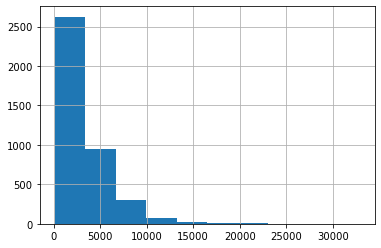

In [19]:
#Plot number of characters in each string
data['Header_and_body'].str.len().hist()


In [20]:
#Function for number of words in each article, plotted as histogram
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

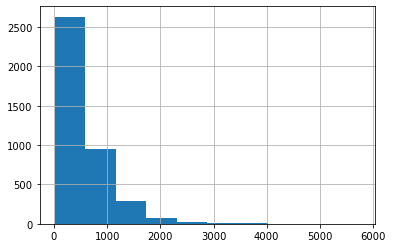

In [21]:
#Run function
plot_word_number_histogram(data['Header_and_body'])

In [22]:
#Function for word lengths within articles
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

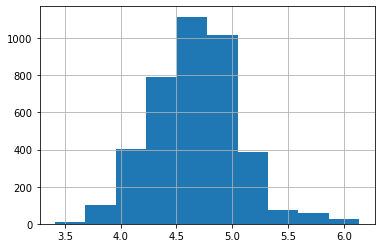

In [23]:
#Run function
plot_word_length_histogram(data['Header_and_body'])

### Initial analysis
Can see that the majority of articles are shorter in length, either under 5000 characters or 1000 words, but the data is right-skewed, within a long tail, accounting for articles up to c22k characters or 4000 words in length.
In short though plenty of text to analysis.
The average word length seems to be around 4 or 5 letters long, which seems very short, but is probably accounted for by the fact that we haven't yet removed the stop words.

In [24]:
#First, filter English stopwords from NLTK library
stop = set(stopwords.words('english'))

#Create the corpus
corpus = []
new = data['Header_and_body'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1



In [25]:
#Function to plot stopwords barchart
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)  

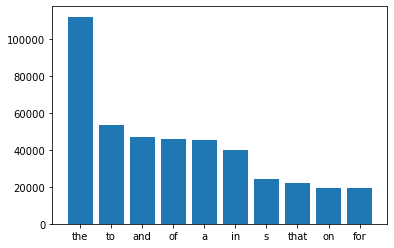

In [26]:
#Run function to produce barchart
plot_top_stopwords_barchart(data['Header_and_body'])

In [27]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:100]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

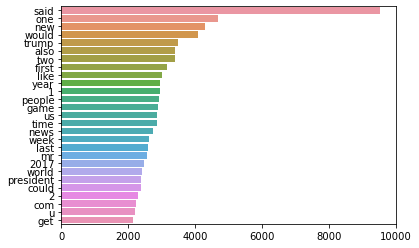

In [28]:
plot_top_non_stopwords_barchart(data['Header_and_body'])

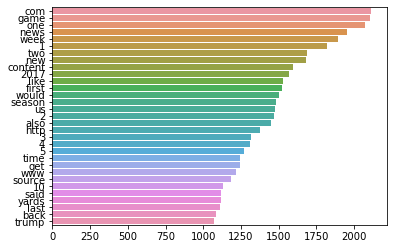

In [29]:
#Look at top non_stopwords in articles labelled as fake
fake = data[data['Label']==0]
plot_top_non_stopwords_barchart(fake['Header_and_body'])

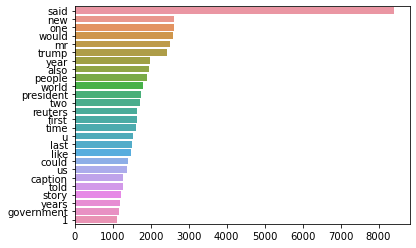

In [30]:
#Look at top non_stopwords in articles labelled as true
true = data[data['Label']==1]
plot_top_non_stopwords_barchart(true['Header_and_body'])

Really interesting that the word "said" features much more heavily in the articles labelled as "true" (c8k occurences compared to 1k). Possibly suggests that increased levels of attribution to, eg, a source, play a significant role in validating information/stories - which is what you might expect. 

### Ngram exploration

Ngrams are simply contiguous sequences of n words. For example “riverbank”, "The three musketeers”, etc. If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.

Looking at most frequent n-grams can give us a better understanding of the context in which the word was used.

In [31]:
#Function for top ngrams and histogram
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

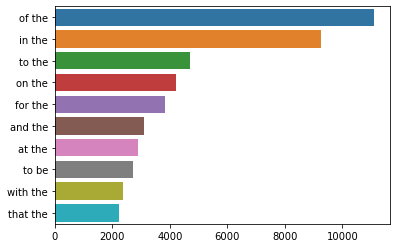

In [32]:
#Run for bi-grams (all articles)
plot_top_ngrams_barchart(data['Header_and_body'], n=2)

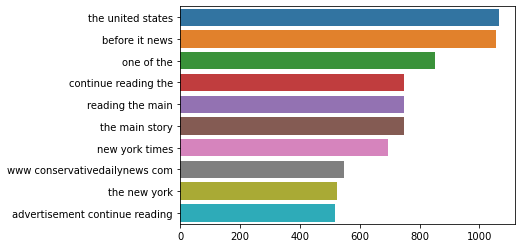

In [33]:
#Run for tri-grams (all articles)
plot_top_ngrams_barchart(data['Header_and_body'], n=3)

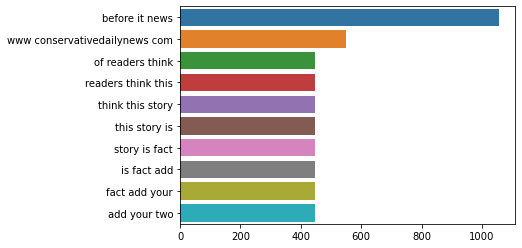

In [34]:
#Run for tri-grams (fake news)
plot_top_ngrams_barchart(fake['Header_and_body'], n=3)

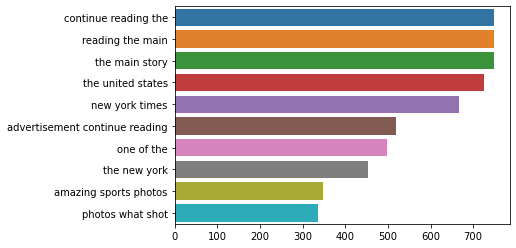

In [35]:
#Run for tri-grams (true news)
plot_top_ngrams_barchart(true['Header_and_body'], n=3)

### Comment
Interesting to see how the articles labelled as false seem to have a preponderance of tri-grams seemingly adressing the reader, or offereing theire engaging them in some way or referencing fact or story, while the true article seem to have more sober/serious tri-grams.




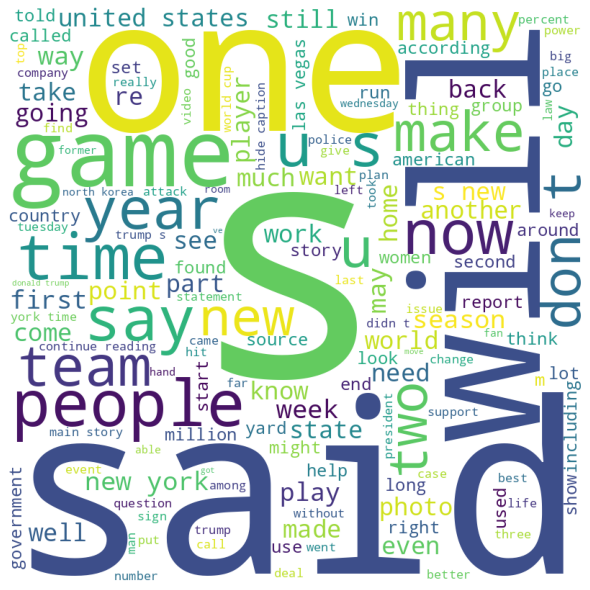

In [36]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in data['Header_and_body']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words = 150,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

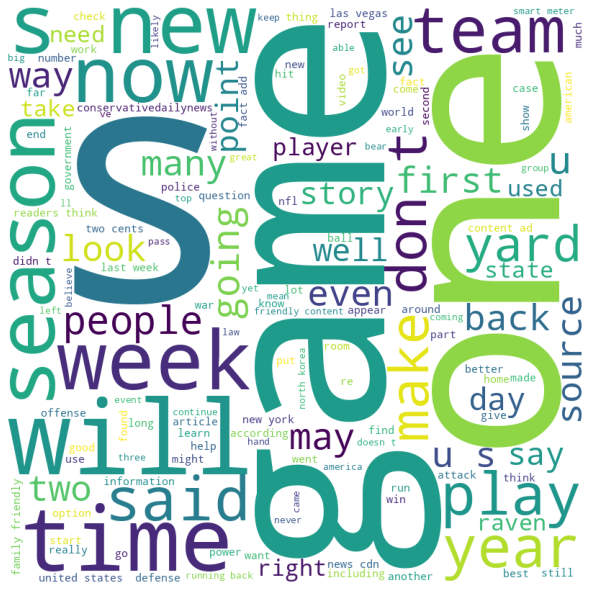

In [37]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in fake['Header_and_body']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words = 150,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

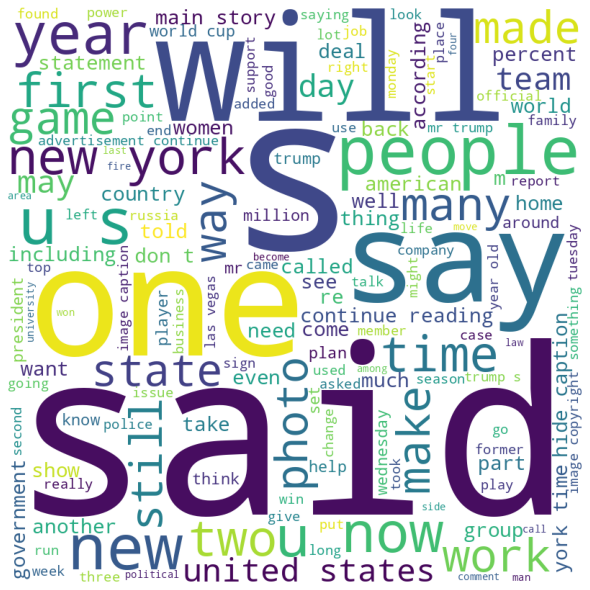

In [38]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in true['Header_and_body']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words = 150,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Comment
Hard to draw any significant conclusions from the Word Clouds, although interesting to difference representations.

## Conclusions
Havinng cleaned and simplified the textual data, and looked at initial analysis, we will save a version of the data withoug stopwords, so that we can start to build and test models o it.

In [39]:
#stop = stopwords.words('english')
data['Header_and_body_NoSWs'] = data['Header_and_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
data['Header_and_body_NoSWs'].head()

0    four ways bob corker skewered donald trump ima...
1    linklater s war veteran comedy speaks modern a...
2    trump s fight corker jeopardizes legislative a...
3    egypt s cheiron wins tie pemex mexican onshore...
4    jason aldean opens snl vegas tribute country s...
Name: Header_and_body_NoSWs, dtype: object

In [40]:
data.columns


Index(['Label', 'Header_and_body', 'Header_and_body_NoSWs'], dtype='object')

In [41]:
data.to_csv('../data/interim/data_cleaned.csv')